In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import cv2
import random
import tensorflow as tf
import seaborn as sns
import os
import random
import keras

from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer, BatchNormalization  
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
                    
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.image import imread
from sklearn.cluster import KMeans

keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


In [2]:
L_images = np.load('l/gray_scale.npy')

In [3]:
AB_images_1 = np.load('ab/ab/ab1.npy')
AB_images_2 = np.load('ab/ab/ab2.npy')
AB_images_3 = np.load('ab/ab/ab3.npy')

In [4]:
L_images.shape

(25000, 224, 224)

In [5]:
AB_images_1.shape

(10000, 224, 224, 2)

In [6]:
AB_images = np.concatenate((AB_images_1, AB_images_2, AB_images_3))

In [7]:
AB_images.shape

(25000, 224, 224, 2)

In [8]:
def prep_L(L_images, batch_size = 300):
    # Create and empty array of given batch size, 224x224, with three channels
    # so that the L channel can fall in a tensor that will eventually hold all three
    # RGB channels
    L_imgs = np.zeros((batch_size, 224, 224, 3))
    # fFr every channel in range 2
    for i in range(0, 3):
        # a new image in the RGB_imgs array will be a greyscale image from L_images
        L_imgs[:batch_size, :, :,i] = L_images[:batch_size]
    # Return the standardized version of this new array.
    return preprocess_input(L_imgs)

In [9]:
def make_RGB(L_images, AB_images, batch_size = 300):
    # Create and empty array of the appropriate size to hold
    # L and AB images. It will be of batch size, 224x244
    # and be composed of three color channels for RGB
    RGB_imgs = np.zeros((batch_size, 224, 224, 3))
    # The first color channel will be the L in L_images, up to the batch size
    RGB_imgs[:, :, :, 0] = L_images[0:batch_size]
    # The second /third color channels will be the AB from AB_images
    RGB_imgs[:, :, :, 1:] = AB_images[0:batch_size]
    # Convert everything to the same file type
    RGB_imgs = RGB_imgs.astype("uint8")
    # Create a new empty list to hold all of the RGB images
    RGB_array = []
    # for every image in the range of the batch size, convert LAB to RGB
    # and then append to our empty list of imgs_
    for i in range(0, batch_size):
        RGB_array.append(cv2.cvtColor(RGB_imgs[i], cv2.COLOR_LAB2RGB))
    # Turn our new list of RGB images back into an array   
    RGB_array = np.array(RGB_array)
    return RGB_array

In [10]:
imgs_input = prep_L(L_images, batch_size = 300)

In [11]:
imgs_output = preprocess_input(make_RGB(L_images, AB_images, batch_size = 300))

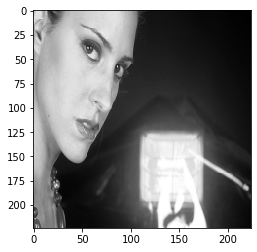

In [12]:
plt.imshow(L_images[25], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


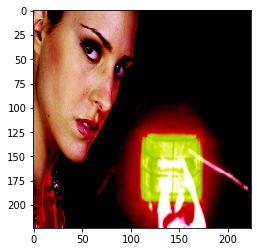

In [14]:
plt.imshow(imgs_output[25]);